In [9]:
!pip install bar_chart_race
!pip install statsmodels
!pip install bokeh
!pip install sktime
!pip install vaderSentiment
!pip install tslearn

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.3/862.3 KB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.1 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [41]:
# Import request library 

In [11]:
import math
import spacy
import warnings
import datetime
import pandas as pd
import numpy as np
import collections
import seaborn as sns
import scipy.stats as stats
import bar_chart_race as bcr
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.formula.api as smf
from tslearn.utils import to_sktime_dataset as sktdata
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster

# from bokeh.plotting import figure
# from bokeh.io import show, output_file
# from bokeh.models import TabPanel, Tabs, Label
# from bokeh.models import Span, ColumnDataSource

from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.base import ForecastingHorizon
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
warnings.filterwarnings('ignore')

Currently, there are 6264473 ratings on BeerAdvocate website


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1500112800,GregKobeArntz24,gregkobearntz24.1206160,4.5,4.75,4.25,4.5,4.50,4.54,NaN,False
1,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1483182000,awjess,awjess.1185716,4.5,4.00,4.25,4.0,4.25,4.11,"Look - Has a nice foamy head, Feel - Creamy ...",False
2,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1468317600,fr0wn3r,fr0wn3r.862994,3.0,3.25,3.00,3.0,3.00,3.06,NaN,False
3,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1459418400,Fatehunter,fatehunter.326927,4.0,3.25,4.00,3.5,3.50,3.52,Pours a finger of head on a hazy darker straw ...,True
4,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1450263600,MTLDOG,mtldog.920333,4.5,3.75,4.00,3.0,3.75,3.52,NaN,False


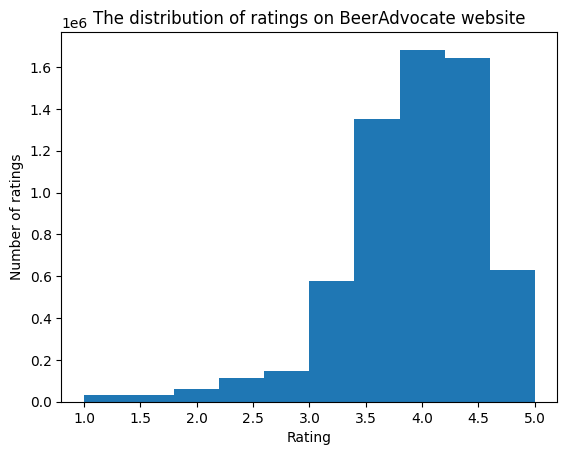

In [12]:
# Load ratings data from BeerAdvocate
df_rating_ba = pd.read_csv('after_pro_data_ba.csv')
df_rating_ba = df_rating_ba.drop(columns=['Unnamed: 0'])
print(f'Currently, there are {len(df_rating_ba)} ratings on BeerAdvocate website')
df_rating_ba.head()

In [ ]:
df_rating_ba.rating.plot.hist()
plt.title('The distribution of ratings on BeerAdvocate website')
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.show()

### Handle the missing value and initial data filtering

In this part, we will handle the missing value and initial data filtering.

In [ ]:
# The scoring attribute
column_ = ['appearance', 'aroma', 'palate', 'taste', 'overall']
print(f'There are {df_rating_ba [column_].isna().any(axis = 1).value_counts()[1]} rows have NAN values in BeerAdvocate')
print(f'There are {np.sum(df_rating_ba [column_].isna().sum(axis = 1)==5)} rows with 5 NAN values in BeerAdvocate')
compare_ba = df_rating_ba[df_rating_ba[column_].isna().any(axis = 1)]
compare_ba['rating'].describe()

Here we found if there is no overall score, there wouldn't be detailed scores about one beer. We also check the website manually, and found that we should rate the appearance, aroma, palate, taste, overall together.
However, these data all have the rating values. We don't think that these data are useful since we want to find some relationship of the detailed score to the rating and other perspectives. And since we will still have very large amout data after deleting them, we will just simply delete them.

In [15]:
#Delete all meaningless lines
df_rating_ba = df_rating_ba[~df_rating_ba[column_].isna().any(axis = 1)]
df_rating_ba.shape

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1500112800,GregKobeArntz24,1206160,4.5,4.75,4.25,4.5,4.50,4.54,NaN,False
1,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1483182000,awjess,1185716,4.5,4.00,4.25,4.0,4.25,4.11,"Look - Has a nice foamy head, Feel - Creamy ...",False
2,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1468317600,fr0wn3r,862994,3.0,3.25,3.00,3.0,3.00,3.06,NaN,False
3,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1459418400,Fatehunter,326927,4.0,3.25,4.00,3.5,3.50,3.52,Pours a finger of head on a hazy darker straw ...,True
4,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1450263600,MTLDOG,920333,4.5,3.75,4.00,3.0,3.75,3.52,NaN,False


In [ ]:
#spilt the user_id in BeerAdvocate
def str_split(data):
    return data.split('.')[1]
df_rating_ba['user_id'] = df_rating_ba['user_id'].apply(str_split)
df_rating_ba.head()

### Datasets preparation and more filtering
We first map the scale of each rating to 0-5 to make a consistency between the two datasets.


In [ ]:
column_list = ['appearance', 'aroma', 'palate', 'taste', 'overall','rating']
list_value = df_rating_ba[column_list].values
min_max_scaler = preprocessing.MinMaxScaler()
list_value_scaler = min_max_scaler.fit_transform(list_value) * 5
data_temp_ba = pd.DataFrame(list_value_scaler,columns=column_list,index = df_rating_ba.index)
df_rating_ba[column_list] = data_temp_ba

df_rating_ba.head()

By doing some simple regression study we find there exist perfect linear relationship between 'overall', 'aroma', 'palate', 'taste', 'overall', 'rating'.

In [ ]:
# Use linear regression to fit our data
mod_ba = smf.ols(formula='rating ~appearance + aroma + palate + taste + overall',data = df_rating_ba)
res_ba = mod_ba.fit()
print(res_ba.summary())
print(f'The R-squared is 1.000 so it is of perfect linear relationship.')

We also find that there exists some ratings that the overall score exceeds the average of the other 4 features(can do this due to the perfect linear relationship). We consider this situation as invalid ratings. Because in common sense, if the detailed features of a beer is good/bad the overall will not be bad/good. And we set the difference threshold to 1.5(in scale of 5).

In [ ]:
df_rating_ba['average'] = df_rating_ba[['appearance','aroma','palate','taste']].mean(axis = 1)
df_rating_ba['diff'] = np.abs(df_rating_ba['overall']-df_rating_ba['average'])
df_rating_ba = df_rating_ba[df_rating_ba['diff'] <1.5]
df_rating_ba = df_rating_ba.drop(columns=['average','diff'])
df_rating_ba.shape

In addition, our analysis will based on the review text later, so we just consider the review as invalid, if there is no text in the review column.

In [21]:
df_rating_ba = df_rating_ba[~df_rating_ba['review']==False]
df_rating_ba.shape

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,3708,cypressbob,1.069326e+09,Northern Ireland


In [24]:
# Load user data from BeerAdvocate
df_user_ba = pd.read_csv('users.csv')
df_user_ba['user_id'] = df_user_ba['user_id'].apply(str_split)
df_user_ba.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN


In [25]:
# Load beer data from BeerAdvocate
df_beer_ba = pd.read_csv('beers.csv')
df_beer_ba.head()

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2


In [ ]:
# Load brewery data from BeerAdvocate
df_brewery_ba = pd.read_csv('breweries.csv')
df_brewery_ba.head()

Merge data based on user id in order to get users' location

In [27]:
#user_region = df_user_ba[['user_id', 'location']]
region_ba = pd.merge(df_rating_ba, df_user_ba, how="left", left_on='user_id', right_on='user_id')

,location,count
0,"United States, Pennsylvania",148288
1,"United States, California",137656
2,"United States, New York",115045
3,"United States, Illinois",100887
4,"United States, Massachusetts",97904
5,"United States, Ohio",83572
6,"United States, Texas",66150
7,Canada,64502
8,"United States, New Jersey",61711
9,"United States, Virginia",57073


In [ ]:
region_agg = region_ba[['location', 'beer_id']].groupby('location').agg('count')
region_agg = pd.DataFrame(region_agg.to_records())
region_agg.rename(columns={'beer_id':'count'}, inplace=True)
region_agg = region_agg.sort_values(by=['count'], ascending=False)
region_agg.reset_index(inplace=True, drop=True)
# Print top 20 region
region_agg.head(20)

## Data Visualization and Choose the popular beers
#### ABV

In [ ]:
avg_ba_abv = region_ba.abv.mean()
avg_ba_abv = round(avg_ba_abv, 2)
print(f'The average abv% of beers from BeerAdvocate is {avg_ba_abv}%.')
fig, ax = plt.subplots()
ax.set_xlim(0, 20)
sns.histplot(region_ba.abv, binwidth=0.5, ax=ax)
plt.title("Abv rankings on BeerAdvocate")
plt.show()

Since we want to make the most popular beer as our motivation, we just study the beers that has abv from its 25% quantile to 75% quantile.

In [ ]:
region_ba_filtered = region_ba[(region_ba.abv.quantile(0.25) <= region_ba.abv) & (region_ba.abv <= region_ba.abv.quantile(0.75))]
region_ba_filtered.shape

#### Style

In [31]:
plt.figure(figsize=(20,10))
sns.histplot(data=region_ba['style'])
plt.xticks(rotation=90)
plt.show()

,style,count
0,American IPA,183955
1,American Double / Imperial IPA,146798
2,American Double / Imperial Stout,95908
3,American Pale Ale (APA),70148
4,Russian Imperial Stout,67380
5,American Porter,54793
6,Saison / Farmhouse Ale,48686
7,American Amber / Red Ale,46612
8,Belgian Strong Dark Ale,40571
9,Fruit / Vegetable Beer,36383


In [ ]:
style_list = region_ba[['style','beer_id']].groupby('style').agg('count')
style_list.rename(columns={'beer_id': 'count'}, inplace=True)
style_list = style_list.sort_values(by='count', ascending=False)
style_list.reset_index(inplace=True)
style_list.head(10)

We also just want to analysis the beer styles with the top 10 popularity

In [ ]:
popular_styles = style_list['style'][:10].to_list()
region_ba_filtered = region_ba_filtered[region_ba_filtered['style'].isin(popular_styles)]
region_ba_filtered.shape

## For user recommendation(Unfinished)

define some variables that the user can input

In [ ]:
abv=5.0
error_range_abv = 0.5
style = region_ba['style'].unique().tolist()[0]
region = region_agg['location'].tolist()[0]
num_of_results_to_show = 10
How = ['popularity', 'Rating']
how = {'popularity': 0, 'Rating': 1}

by popularity

In [35]:
df_beer_ba.head()

In [36]:
selected = df_beer_ba[df_beer_ba.abv.isin(np.linspace(abv-error_range_abv, abv+error_range_abv, 10))]

[29602, 16520, 1822, 71106, 43835, 47166, 2778, 7492, 9091, 79393]

In [ ]:
selected = selected[selected['style'] == style]
selected.sort_values(by='nbr_reviews', ascending=False, inplace=True)
selected_beer_id_by_popularity = selected.beer_id.tolist()[:num_of_results_to_show]
selected_beer_id_by_popularity

by_rating_avg

In [38]:
selected = region_ba[region_ba.abv.isin(np.linspace(abv-error_range_abv, abv+error_range_abv, 10))]
selected = selected[selected['style'] == style]
selected_beer_avgRating = selected[['beer_id', 'rating']].groupby('beer_id').agg('mean')
selected_beer_avgRating.sort_values(by='rating', ascending=False, inplace=True)
selected_beer_avgRating.reset_index(inplace=True)
selected_beer_name_by_avgRating = df_beer_ba[df_beer_ba.beer_id.isin(selected_beer_avgRating['beer_id'].to_list()[:num_of_results_to_show])][['beer_id', 'beer_name']]
selected_beer_name_by_avgRating = selected_beer_name_by_avgRating.beer_id.to_list()
selected_beer_name_by_avgRating

In [ ]:
selected_id_list = [selected_beer_id_by_popularity, selected_beer_name_by_avgRating]

Here the ```selected_list``` is the beer info list that we may recommend to the user and ```selected_beer_name_by_How``` is the top ```num_of_results_to_show``` beer_id to show.

In [ ]:
beer_to_show = df_beer_ba[df_beer_ba['beer_id'].isin(selected_id_list[how[How[0]]])]
beer_to_show = beer_to_show[['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
                             'nbr_ratings', 'nbr_reviews']]
beer_to_show['Top5 keywords'] = ''

Then we want to analyze the review texts to get the top 5 keywords for user's reference.

## Sentiment Analysis for BeerAdvocate reviews


In this part, we will analyze the sentiment of BeerAdvocate reviews in order to determine whether the positive / negative proportion in review is related to the trend of beer popularity.

In [43]:
analyzer = SentimentIntensityAnalyzer()
df_sentiment_ba = region_ba_filtered.copy()

# Because some text just in type of float, we need to convert it to string
df_sentiment_ba.text = df_sentiment_ba.text.astype(str)

In [44]:
# Get sentiment score for each review

positive_list, negative_list, neutral_list = [], [], []
pos, neg, neu, compound = [], [], [], []

for i in range(df_sentiment_ba.shape[0]):
    text = df_sentiment_ba.iloc[i]['text']
    vs = analyzer.polarity_scores(text)
    positive = 1 if vs['compound'] >= 0.5 else 0
    negative = 1 if vs['compound'] <= -0.5 else 0
    neutral = 1 if vs['compound'] > -0.5 and vs['compound'] < 0.5 else 0
    positive_list.append(positive)
    negative_list.append(negative)
    neutral_list.append(neutral)
    pos.append(vs['pos'])
    neg.append(vs['neg'])
    neu.append(vs['neu'])
    compound.append(vs['compound'])

df_sentiment_ba['positive'] = positive_list
df_sentiment_ba['negative'] = negative_list
df_sentiment_ba['neutral'] = neutral_list
df_sentiment_ba['pos'] = pos
df_sentiment_ba['neg'] = neg
df_sentiment_ba['neu'] = neu


In [ ]:
# Change to datetime
df_sentiment_ba['date'] = df_sentiment_ba.date.apply(lambda x: datetime.datetime.fromtimestamp(x).year)

### Fine the fraction of negative reviews in ['American IPA', 'American Double / Imperial IPA', 'American Porter']

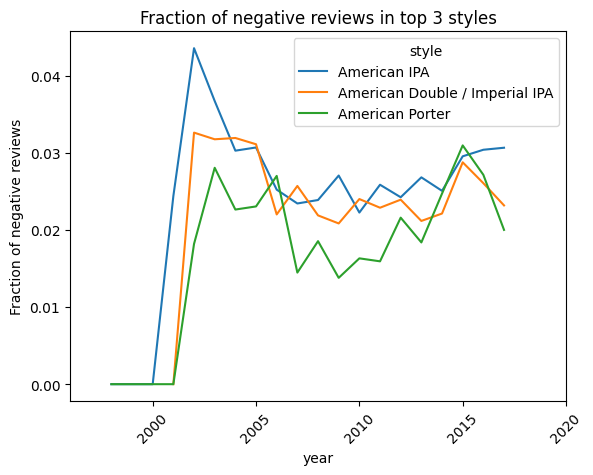

In [46]:
style_name = ['American IPA', 'American Double / Imperial IPA', 'American Porter']

df_sentiment_ba_topStyle = pd.DataFrame(columns=['year', 'style', 'fraction_negative'])

for style in style_name:
    tmp = df_sentiment_ba[df_sentiment_ba['style'] == style]
    tmp_neg_nums = tmp[['date', 'negative']].groupby('date').agg('sum')['negative']
    tmp_nums = tmp[['date', 'beer_id']].groupby('date').agg('count')['beer_id']
    tmp = (tmp_neg_nums / tmp_nums).reset_index()
    tmp.columns = ['year', 'fraction_negative']
    tmp['style'] = style
    df_sentiment_ba_topStyle = pd.concat([df_sentiment_ba_topStyle, tmp])

In [ ]:
df_sentiment_ba_topStyle['year'] = df_sentiment_ba_topStyle['year'].astype(int)

sns.lineplot(data=df_sentiment_ba_topStyle, x='year', y='fraction_negative', hue='style')
plt.title('Fraction of negative reviews in top 3 styles')
plt.ylabel('Fraction of negative reviews')
plt.xticks(rotation=45)
plt.xlim(1996, 2020)
plt.show()

The figure above is similar to the trend of the number of reviews over time.

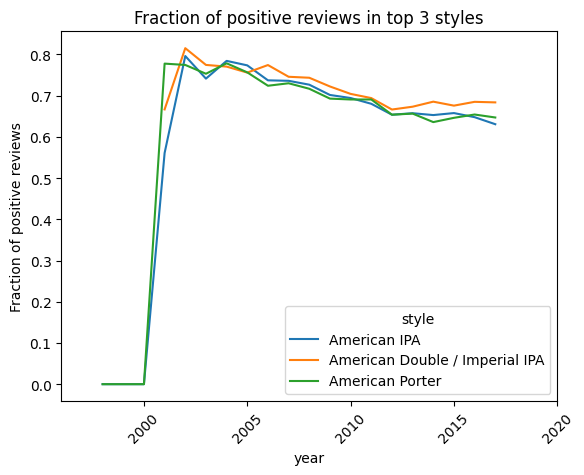

In [48]:
df_sentiment_ba_topStyle = pd.DataFrame(columns=['year', 'style', 'fraction_positive'])


for style in style_name:
    tmp = df_sentiment_ba[df_sentiment_ba['style'] == style]
    tmp_neg_nums = tmp[['date', 'positive']].groupby('date').agg('sum')['positive']
    tmp_nums = tmp[['date', 'beer_id']].groupby('date').agg('count')['beer_id']
    tmp = (tmp_neg_nums / tmp_nums).reset_index()
    tmp.columns = ['year', 'fraction_positive']
    tmp['style'] = style
    df_sentiment_ba_topStyle = pd.concat([df_sentiment_ba_topStyle, tmp])

In [ ]:
df_sentiment_ba_topStyle['year'] = df_sentiment_ba_topStyle['year'].astype(int)

sns.lineplot(data=df_sentiment_ba_topStyle, x='year', y='fraction_positive', hue='style')
plt.title('Fraction of positive reviews in top 3 styles')
plt.ylabel('Fraction of positive reviews')
plt.xticks(rotation=45)
plt.xlim(1996, 2020)
plt.show()

In here, we could notice that the fraction of positive reviews is slowly decreasing over time.

### Builde a linear regression model to predict the rating based on the sentiment score

In [ ]:
mod = smf.ols(formula="overall ~ neg * neu * pos", data=df_sentiment_ba)
result = mod.fit()
print('RatingBeer Sentiment Analysis')
result.summary()

We could notice that the R-Squared is too low, which means the sentiment score is not a good predictor for the rating.

### Find the most frequent ADJ word in the negative review text

In [56]:
!pip install spacy

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [54]:
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 15000000
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

def Find_Frequent_Words(text):

    """
    Find the most frequent words in the text
    Input: text (For short database)
    Output: a list of most frequent words
    """

    doc = nlp(text)
    doc = [token for token in doc if token.is_stop != True and token.is_punct != True]
    df_freq_words = pd.DataFrame(columns=['word','pos','count'])
    df_freq_words['word'] = [token.lemma_ for token in doc]
    df_freq_words['pos'] = [token.pos_ for token in doc]
    df_freq_words['count'] = 1
    df_freq_words.groupby(['word', 'pos']).agg('sum').reset_index().sort_values(by='count', ascending=False)

    return df_freq_words

NameError: name 'Find_Frequent_Words' is not defined

In [ ]:
example = 'I want you contact someone, The company is sending out leaflets to all its contacts'
Find_Frequent_Words(example)

In [ ]:
def Fine_Frequent_Words_Big(df):
    """
    Find the most frequent words in the text
    Input: df (For big database)
    Output: a list of most frequent words
    """

    df_freq_words = pd.DataFrame(columns=['word', 'count','pos'])
    for i in range(0, len(df), 1000):
        temp = df[i:i+1000]
        text = ''.join(temp['text'])
        df_freq_words_tmp = Find_Frequent_Words(text)
        df_freq_words = pd.concat([df_freq_words, df_freq_words_tmp], axis=0)
        df_freq_words = df_freq_words.groupby(['word','pos']).sum()
        df_freq_words = df_freq_words.sort_values(by='count', ascending=False)
        df_freq_words = df_freq_words.reset_index()
    return df_freq_words

In [ ]:
df_negative_review = df_sentiment_ba.copy()
df_negative_review = df_negative_review[(df_negative_review['negative'] == 1) & (df_negative_review['overall'] < 3.5)]

df_freq_word = Fine_Frequent_Words_Big(df_negative_review)

sns.barplot(x='count', y='word', data=df_freq_word[df_freq_word['pos'] == 'ADJ'].head(20))
plt.title('Top 20 frequent ADJ words in negative review')
plt.show()

We wanted to know the adjectives that appear most often in negative reviews and that contain what consumers are not satisfied with about these beers. The brewery can use these words to improve their beers.

In [ ]:
sns.barplot(x='count', y='word', data=df_freq_word[df_freq_word['pos'] == 'NOUN'].head(20))
plt.title('Top 20 frequent NOUN words in negative review')
plt.show()

### For each brewery, find the most frequent ADJ word

In [ ]:
most_popular_brewery = list(region_ba_filtered['brewery_name'].value_counts().index[:5])

In [ ]:
most_popular_brewery

In [ ]:
df_sentiment_ba_brewery = df_sentiment_ba[df_sentiment_ba['brewery_name'] == most_popular_brewery[0]]

In [ ]:
df_negative_review_brewery = df_sentiment_ba_brewery[df_sentiment_ba_brewery['negative'] == 1]

df_freq_word_brewery = Fine_Frequent_Words_Big(df_negative_review_brewery)
sns.barplot(x='count', y='word', data=df_freq_word_brewery[df_freq_word_brewery['pos'] == 'ADJ'].head(20))
plt.title(f'Top 20 frequent ADJ and NOUN words in {most_popular_brewery[0]} ')
plt.show()

In [ ]:
sns.barplot(x='count', y='word', data=df_freq_word_brewery[(df_freq_word_brewery['pos'] == 'ADJ') | (df_freq_word_brewery['pos'] == 'NOUN')].head(20))
plt.title(f'Top 20 frequent ADJ and NOUN words in {most_popular_brewery[0]} ')
plt.show()

Find the most frequent ADJ word in most popular region

In [ ]:
region_ba_filtered.head()

In [ ]:
most_popular_region = list(region_ba_filtered['location'].value_counts().index[:3])

['United States, Pennsylvania',
 'United States, California',
 'United States, New York']

In [ ]:
most_popular_region

In [ ]:
from wordcloud import WordCloud

In [ ]:
for region in most_popular_region:
    df_sentiment_ba_region = df_sentiment_ba[df_sentiment_ba['location'] == region]
    df_freq_word_region = Fine_Frequent_Words_Big(df_sentiment_ba_region)
    sns.barplot(x='count', y='word', data=df_freq_word_region[(df_freq_word_region['pos'] == 'ADJ') | (df_freq_word_region['pos'] == 'NOUN')].head(20))
    plt.title(f'Top 20 frequent ADJ and NOUN words in {region} ')
    plt.show()

    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
    words = {}
    for i in range(20):
        words[df_freq_word_region['word'][i]] = df_freq_word_region['count'][i]

    wordcloud = wordcloud.generate_from_frequencies(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Top 20 frequent ADJ and NOUN words in {region} ')
    plt.show()



We first want to do some analysis on beers,
since we want to make popular beers, we first investigate top 3 style with the most number of reviews.

In [ ]:
# make a copy of the dataframe, only retain the useful columns
df = region_ba_filtered.copy()
df = df.drop(columns=['user_name_y','review','joined','text','user_name_x','user_id'])
df['date'] = df.date.apply(lambda x: datetime.datetime.fromtimestamp(x).year)

select the top 3 styles

In [ ]:
style_top_3 = df.groupby('style').count().reset_index().sort_values(by = 'beer_name', ascending=False)[['style']][:3]['style'].to_list()
style_top_3

By previous study the year ranges from 1998 to 2017

In [ ]:
year_list = [i+1998 for i in range(20)]

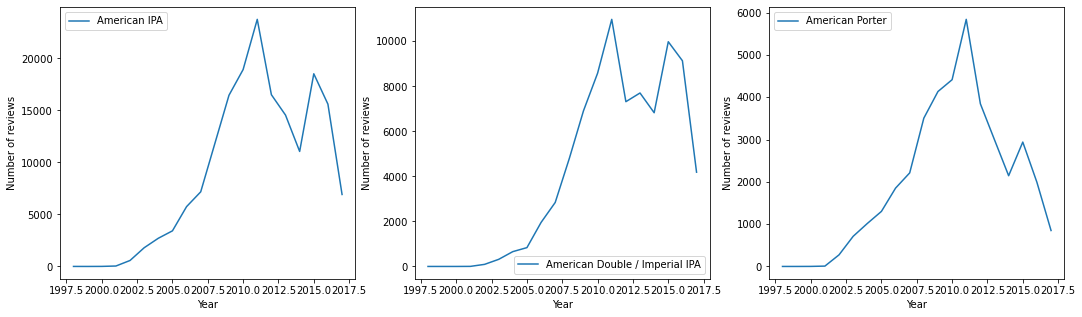

In [ ]:
temp_dict = {}
for style in style_top_3:
    temp_dict[style] = []
    for year in year_list:
        tempdf = df[df['style'] == style]
        year_count = len(tempdf[tempdf['date']==year])
        temp_dict[style].append(year_count)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(18,5))
for idx, key in enumerate(temp_dict.keys()):
    count = pd.DataFrame(temp_dict[key], year_list)
    sns.lineplot(x=count.index, y=count[0], data=count, ax = ax[idx], legend=True, label= key, palette='rainbow')
    ax[idx].legend(prop={'size': 10})
    ax[idx].set_ylabel('Number of reviews')
    ax[idx].set_xlabel('Year')

We found that the number of review decreases after 2010, but why?
Let's then have a look at the total number of review in each year.

In [ ]:
temp_list = []
for year in year_list:
    year_count = len(df[df['date']==year])
    temp_list.append(year_count)
temp_list = pd.DataFrame(temp_list, year_list)
sns.lineplot(x=temp_list.index, y=temp_list[0], data=temp_list)
plt.ylabel("Number of review")
plt.xlabel("Year")
plt.title("Total Number of Reviews in Every Year")
plt.show()

We can see that the total number of reviews is also decreasing, This may due to the number of active users on the website is decreasing. To factor this effect out, we use the fraction of the number of reviews of each style.G

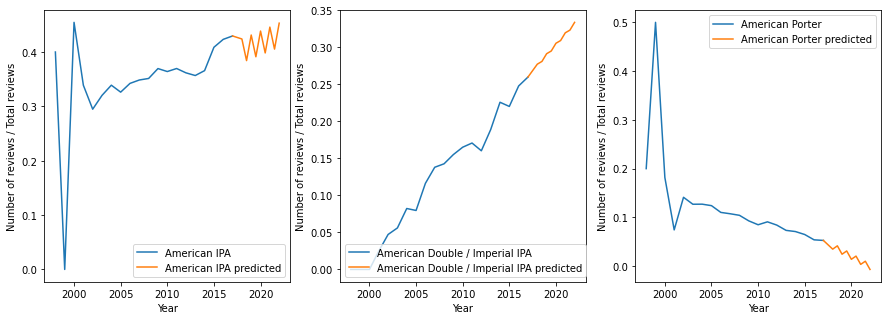

In [ ]:
def plot_style_style_frac_worldwide(style_top_3=style_top_3, year_list=year_list, prediction=False):
    fraction_dict_top3_style = {}
    for style in style_top_3:
        fraction_dict_top3_style[style] = []
        for year in year_list:
            year_tot = len(df[df.date == year])
            tempdf = df[df['style'] == style]
            year_frac = len(tempdf[tempdf['date']==year]) / year_tot
            fraction_dict_top3_style[style].append(year_frac)
    year_to_plot = year_list
    Y_to_plot = fraction_dict_top3_style
    if prediction:
        for style in style_top_3:
            x = year_list# train data x
            y = fraction_dict_top3_style[style]
            y = [i+1 for i in y]
            Y = pd.DataFrame(x, y).reset_index()

            X = [i for i in range(1,10)] ## 往后预测多少年
            fh = ForecastingHorizon(X, is_relative=True)
            forecaster = ThetaForecaster(sp=2)
            forecaster.fit(y=Y)
            y_pred = forecaster.predict(fh = fh)
            year_to_plot = year_list + [year_list[-1]] + y_pred[0].to_list()
            Y_to_plot[style].append(Y_to_plot[style][-1])
            Y_to_plot[style].extend(y_pred['index']-1)

    fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15,5))
    for idx, key in enumerate(Y_to_plot.keys()):
        count = pd.DataFrame(Y_to_plot[key], year_to_plot)
        # print(count.index)
        # print(count[0])
        sns.lineplot(x=count.index[:len(year_list)], y=count[0].iloc[:len(year_list)], data=count.iloc[:len(year_list)], ax = ax[idx], legend=True, label= key, palette="rainbow")
        sns.lineplot(x=count.index[len(year_list):], y=count[0].iloc[len(year_list):], data=count.iloc[len(year_list):], ax = ax[idx], legend=True, label= key+" predicted", palette="rainbow")

        ax[idx].legend(prop={'size': 10})
        ax[idx].set_ylabel('Number of reviews / Total reviews')
        ax[idx].set_xlabel('Year')

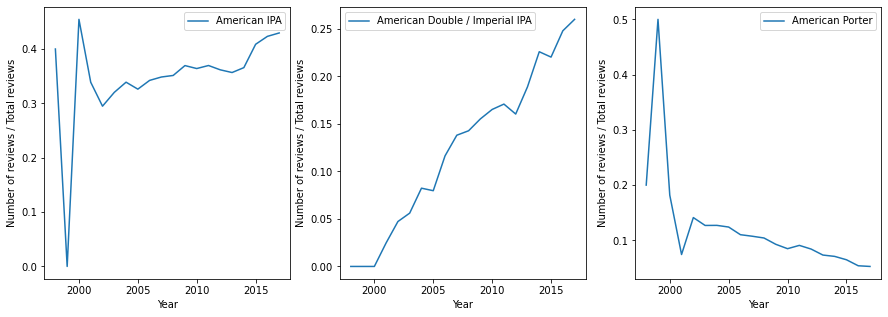

In [ ]:
plot_style_style_frac_worldwide(style_top_3, year_list,True)

In [ ]:
plot_style_style_frac_worldwide(style_top_3, year_list)

Now this can reveal the trend, we can learn that "American IPA" and "American Double/Imperial"" IPA's number of reviews are increasing worldwide, while that of "American Porter" is becoming less dominant.

**Next step: find and analyze the reasons behind the above trend.**
**_(May have a look at the trend of the number of positive, negative reviews of that styles in each year_**


Here, we may tell that the breweries should lay more emphasis on the production of beers of type "American IPA" and "American Double/Imperial IPA", while give less attention to the production of "American Porter" Beer.

In [ ]:
df.columns

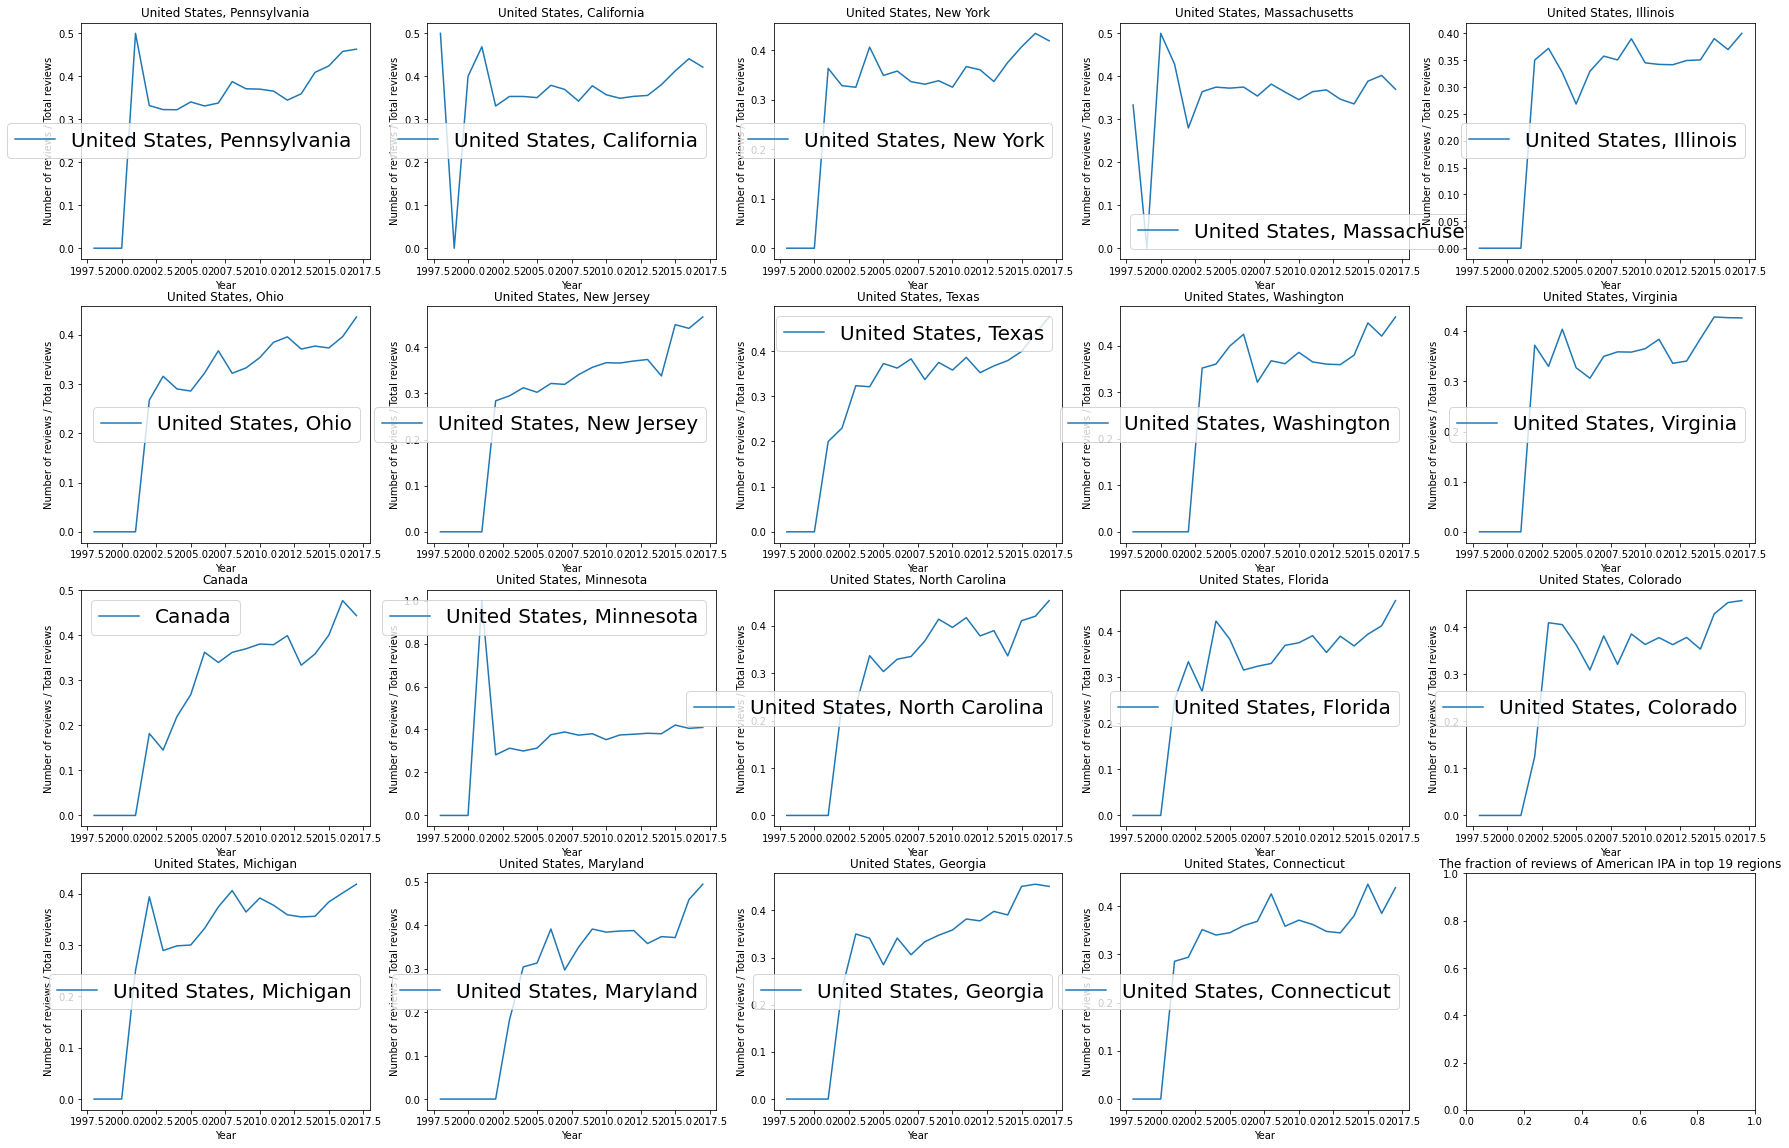

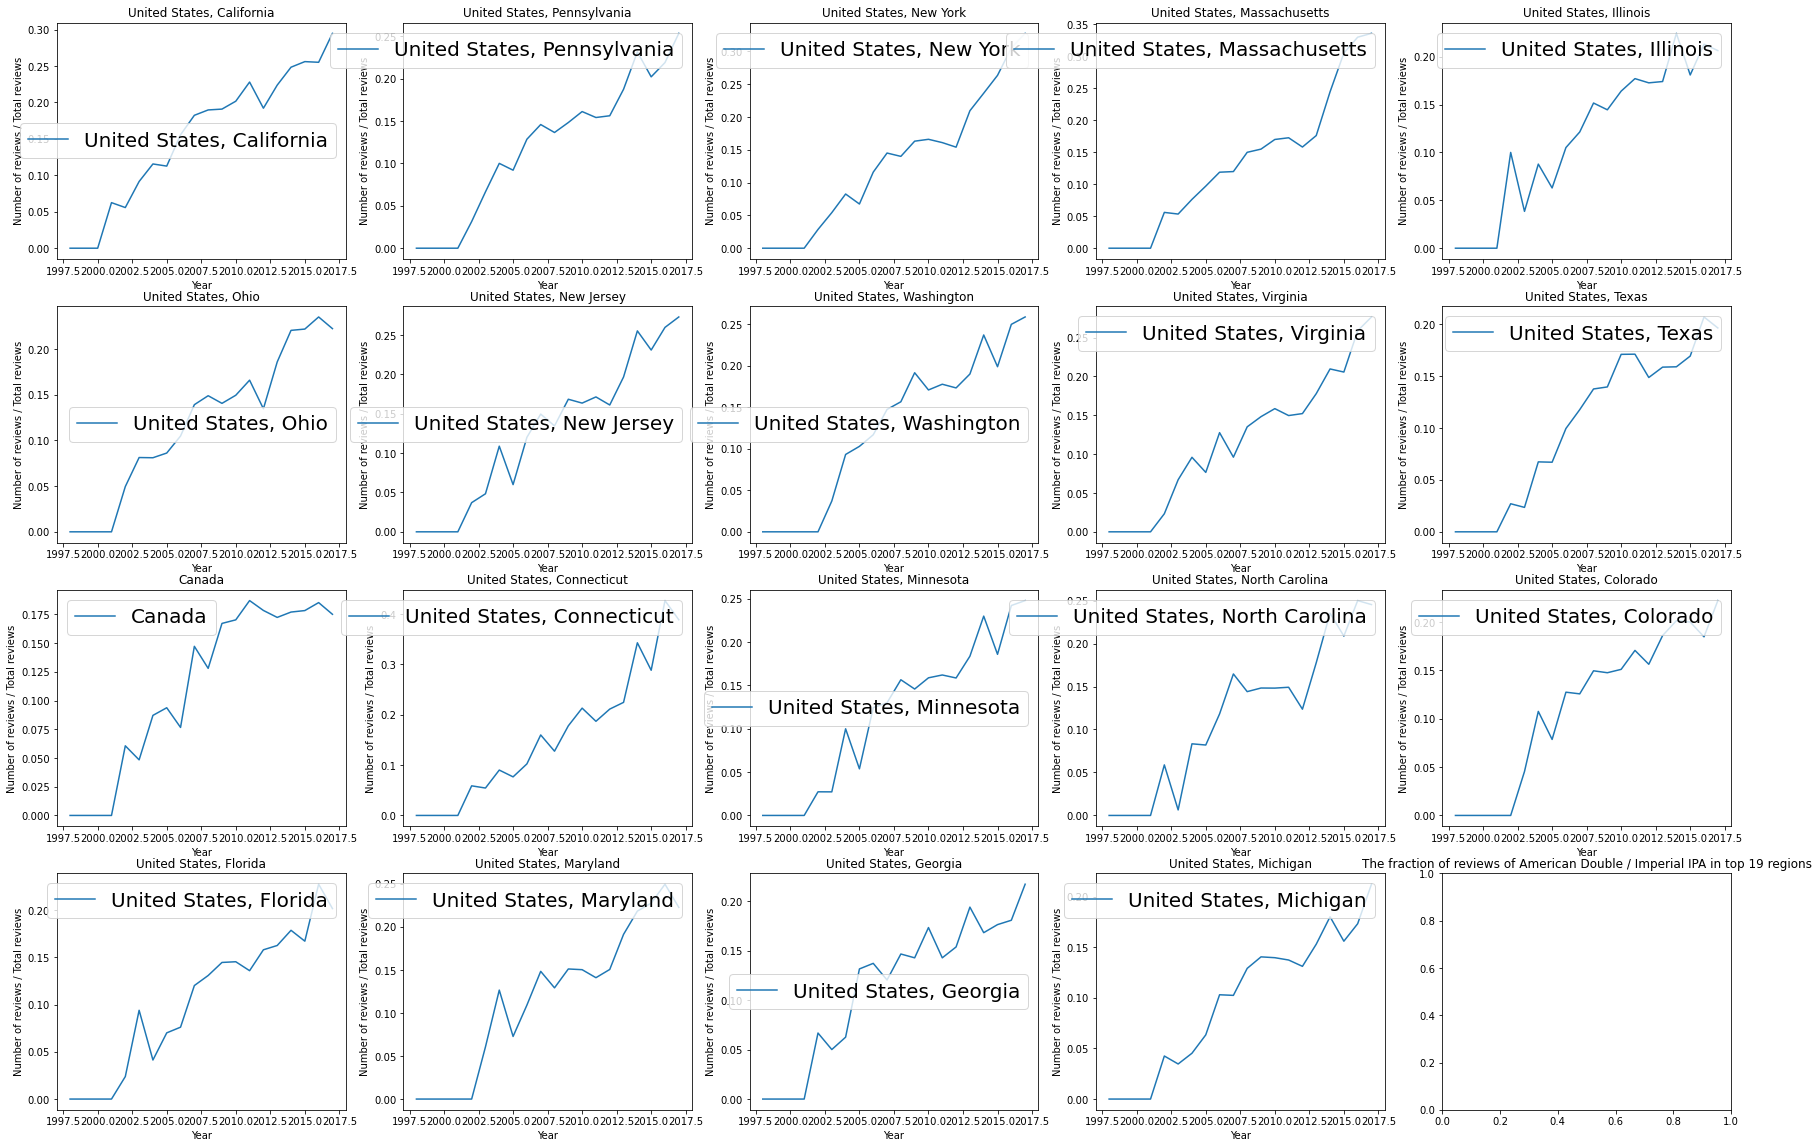

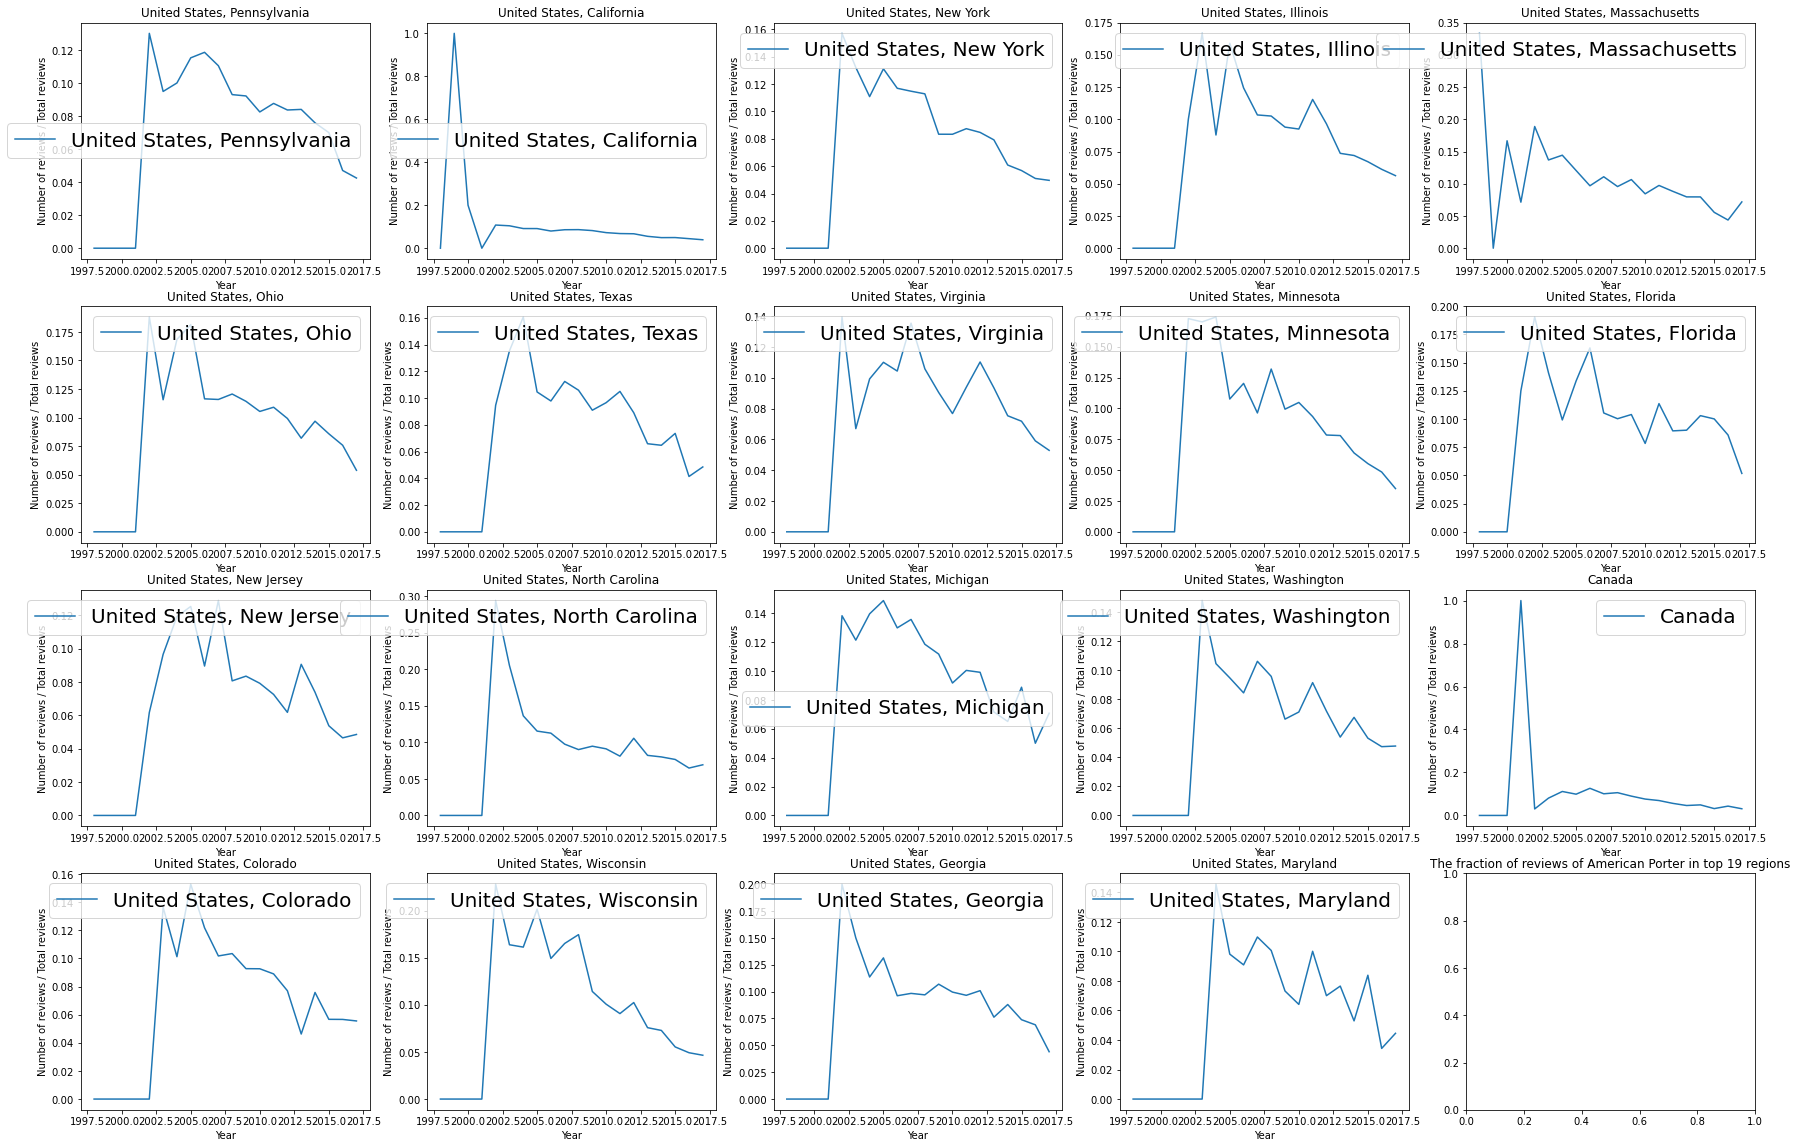

In [ ]:
# define the function to plot the top 5 regions that have reviews of one particular type
def plot_style_region(style=None, number_regions=5, data_frame=df):

    data = data_frame[data_frame['style'] == style]
    region_list = data[['location', 'beer_id']].groupby('location').agg('count')
    region_list.rename(columns={'beer_id': 'count'}, inplace=True)
    region_list = region_list.sort_values(by='count', ascending=False)
    region_list.reset_index(inplace=True)
    region_list = region_list.iloc[:number_regions]['location'].to_list()
    # print(region_list)
    fraction_dict_top_regions = {}
    if number_regions <= 5:
        fig, ax = plt.subplots(1, number_regions, figsize = (30, 5))
    else:
        fig, ax = plt.subplots(number_regions//5 + 1, 5, figsize = (30, 5*number_regions//5 + 1))
    plt.title(f'The fraction of reviews of {style} in top {number_regions} regions')
    for location in region_list:
        fraction_dict_top_regions[location] = []
        for year in year_list:
            temp = data_frame[data_frame['date']==year]
            num_reviews_region_year = len(temp[temp['location']==location])
            temp2 = data[data['date']==year]
            if num_reviews_region_year == 0:
                frac_reviews_style_region_year = 0
            else:
                frac_reviews_style_region_year = len(temp2[temp2['location']==location]) / num_reviews_region_year
            fraction_dict_top_regions[location].append(frac_reviews_style_region_year)
    for idx, key in enumerate(fraction_dict_top_regions.keys()):
        count = pd.DataFrame(fraction_dict_top_regions[key], year_list)
        if number_regions > 5:
            sns.lineplot(x=count.index, y=count[0], data=count, ax = ax[math.floor(idx/5), idx%5], legend=True, label= key, palette='rainbow')
            ax[math.floor(idx//5), idx%5].legend(prop={'size': 20})
            ax[math.floor(idx//5), idx%5].set_ylabel('Number of reviews / Total reviews')
            ax[math.floor(idx//5), idx%5].set_xlabel('Year')
            ax[math.floor(idx//5), idx%5].set_title(key)
        else:
            sns.lineplot(x=count.index, y=count[0], data=count, ax = ax[idx], legend=True, label= key, palette='rainbow')
            ax[idx].legend(prop={'size': 20})
            ax[idx].set_ylabel('Number of reviews / Total reviews')
            ax[idx].set_xlabel('Year')
            ax[idx].set_title(key)

In [ ]:
for style in style_top_3:
    plot_style_region(style, 19, df)

NEXT: **Give suggestions to breweries**


**_Find the relationship between the fraction of reviews and the fraction of negative reviews_**
https://www.zhihu.com/question/47644076   （负面评价会以怎样的方式影响消费决策）

ALE style分析

In [ ]:
df_2 = region_ba_filtered.copy()
df_2 = df_2.drop(columns=['user_name_y','review','joined','text','user_name_x','user_id'])
df_2['date'] = df_2.date.apply(lambda x: datetime.datetime.fromtimestamp(x).year)

,style
3,American IPA
1,American Double / Imperial IPA
5,American Porter
9,Saison / Farmhouse Ale
4,American Pale Ale (APA)
0,American Amber / Red Ale
6,Belgian Strong Dark Ale
2,American Double / Imperial Stout
8,Russian Imperial Stout
7,Fruit / Vegetable Beer


In [ ]:
df_2.groupby('style').count().reset_index().sort_values(by = 'beer_name',ascending=False)[['style']]

['American Amber / Red Ale',
 'American Pale Ale (APA)',
 'Belgian Strong Dark Ale',
 'Saison / Farmhouse Ale']

In [ ]:
style_ale = ['American Amber / Red Ale','American Pale Ale (APA)','Belgian Strong Dark Ale','Saison / Farmhouse Ale']
style_ale

In [ ]:
year_list = [i+1998 for i in range(20)]

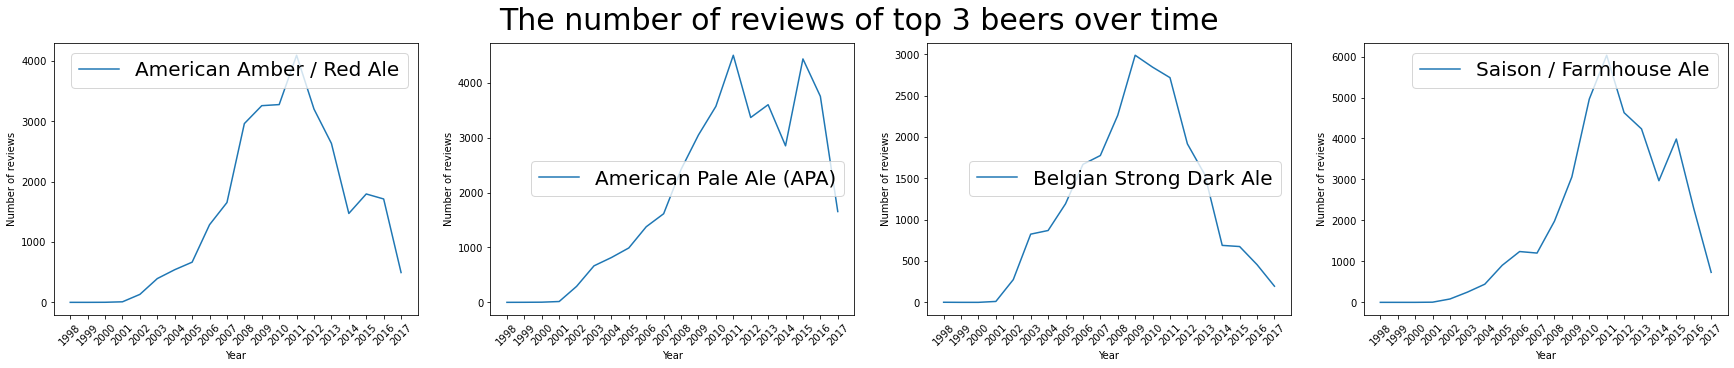

In [ ]:
temp_dict2 = {}
for style in style_ale:
    temp_dict2[style] = []
    for year in year_list:
        tempdf_2 = df_2[df_2['style'] == style]
        year_count = len(tempdf_2[tempdf_2['date']==year])
        temp_dict2[style].append(year_count)

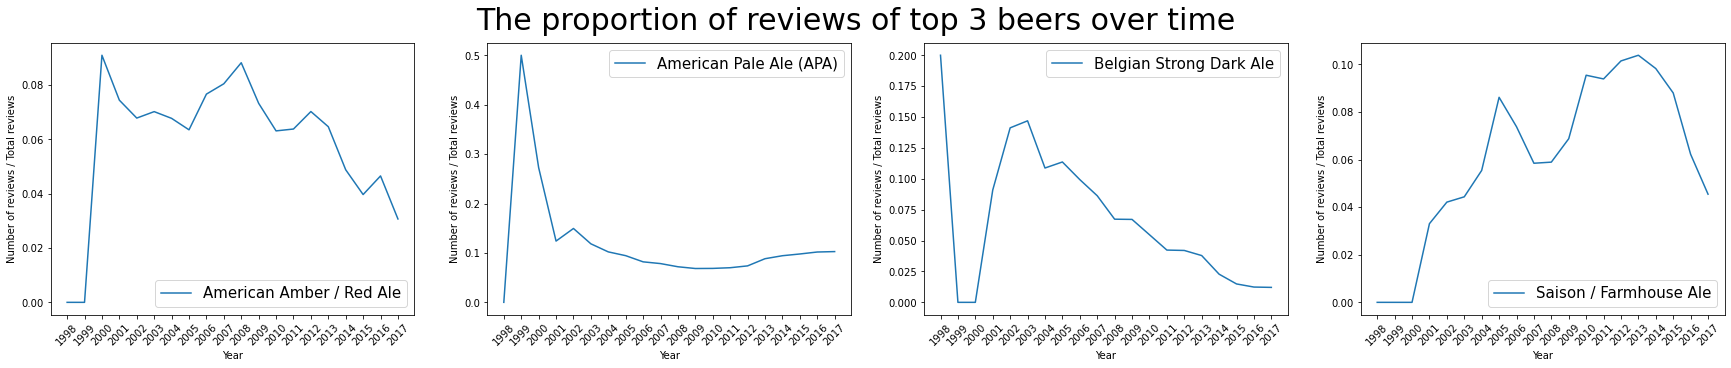

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(30,5))
for idx, key in enumerate(temp_dict2.keys()):
    count = pd.DataFrame(temp_dict2[key], year_list)
    sns.lineplot(x=count.index.values.astype(str), y=count[0], data=count, ax = ax[idx], legend=True, label= key, palette='rainbow')
    ax[idx].legend(prop={'size': 20})
    ax[idx].set_ylabel('Number of reviews')
    ax[idx].set_xlabel('Year')
    ax[idx].set_xticklabels(count.index.values.astype(str), rotation=45)
fig.suptitle("The number of reviews of top 3 beers over time ", fontsize=30)
plt.show()

In [ ]:
fraction_dict_style_ale = {}
for style in style_ale:
    fraction_dict_style_ale[style] = []
    for year in year_list:
        year_tot = len(df_2[df_2.date == year])
        tempdf_2 = df_2[df_2['style'] == style]
        year_frac = len(tempdf_2[tempdf_2['date']==year]) / year_tot
        fraction_dict_style_ale[style].append(year_frac)

fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(30,5))
for idx, key in enumerate(fraction_dict_style_ale.keys()):
    count = pd.DataFrame(fraction_dict_style_ale[key], year_list)
    sns.lineplot(x=count.index.astype(str), y=count[0], data=count, ax = ax[idx], legend=True, label= key, palette='rainbow')
    ax[idx].legend(prop={'size': 15})
    ax[idx].set_ylabel('Number of reviews / Total reviews')
    ax[idx].set_xlabel('Year')
    ax[idx].set_xticklabels(count.index.values.astype(str), rotation=45)
fig.suptitle("The proportion of reviews of top 3 beers over time ", fontsize=30)
plt.show()

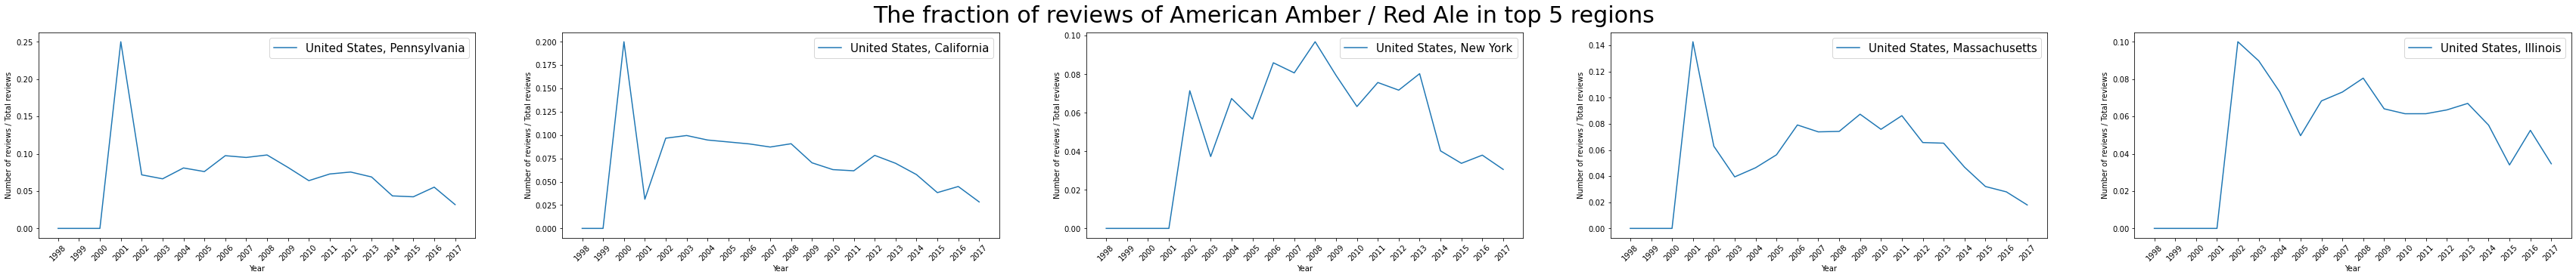

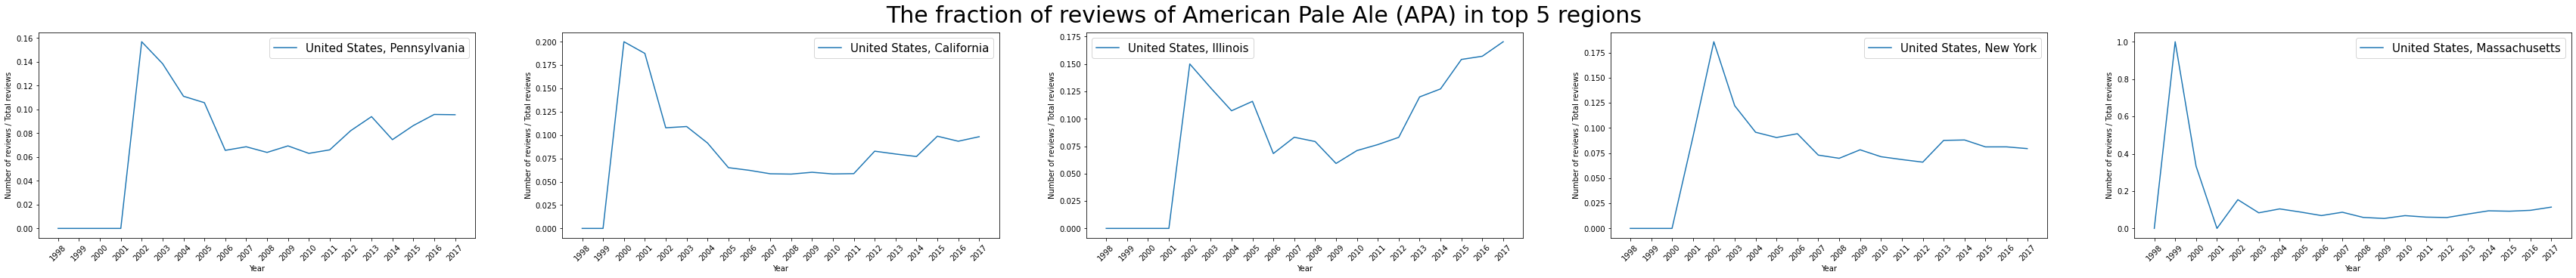

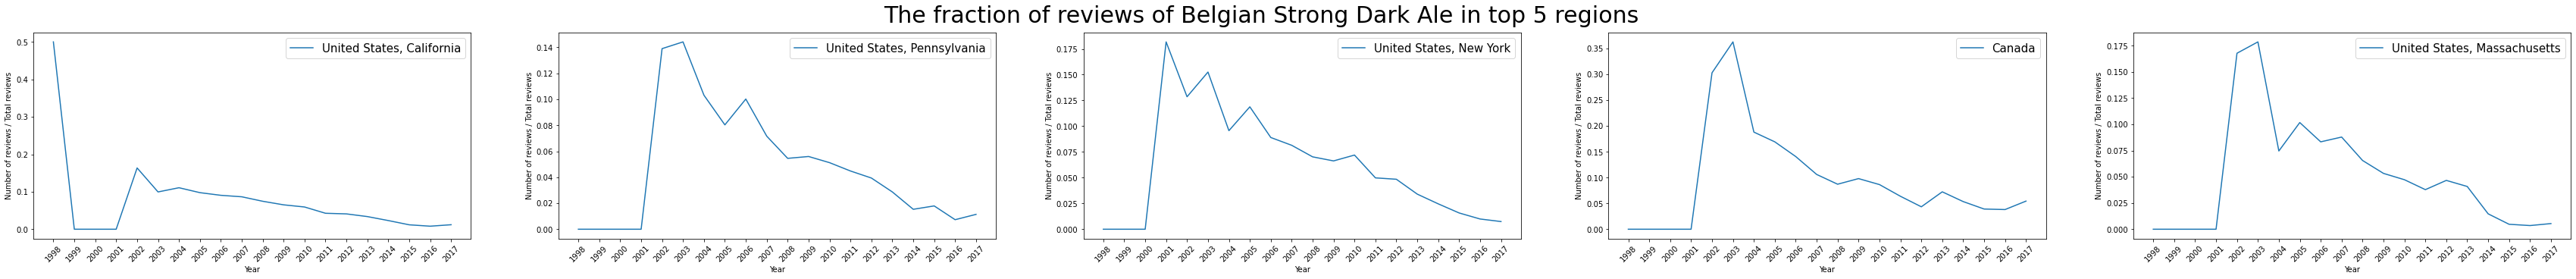

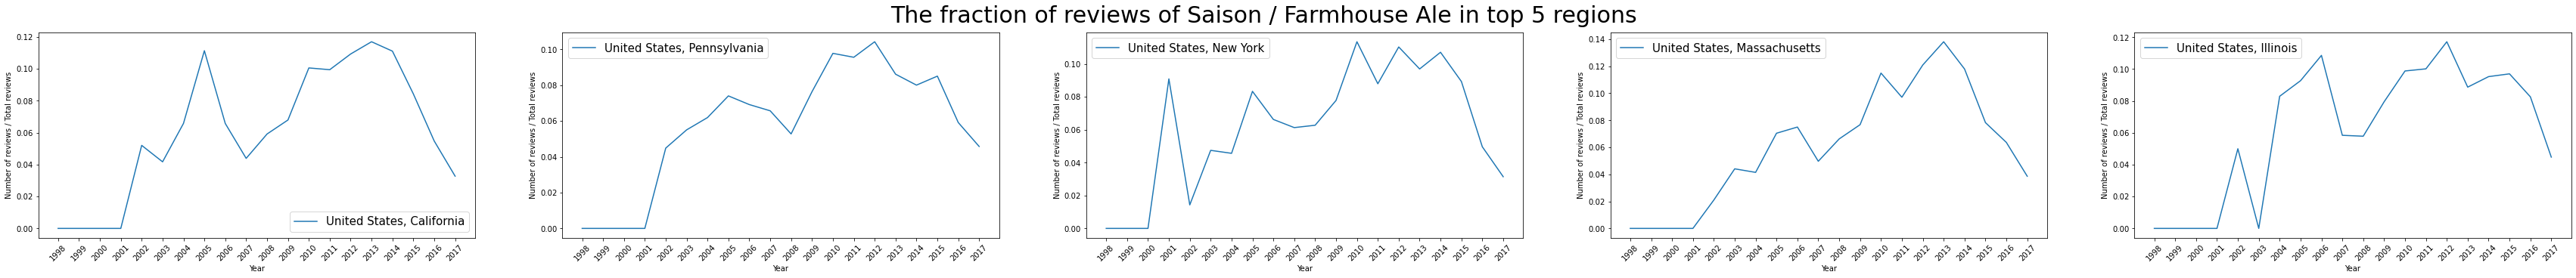

In [ ]:
def plot_style_region(style=None, number_regions=5, data_frame=df):

    data = data_frame[data_frame['style'] == style]
    region_list = data[['location', 'beer_id']].groupby('location').agg('count')
    region_list.rename(columns={'beer_id': 'count'}, inplace=True)
    region_list = region_list.sort_values(by='count', ascending=False)
    region_list.reset_index(inplace=True)
    region_list = region_list.iloc[:number_regions]['location'].to_list()
    # print(region_list)
    fraction_dict_top_regions = {}
    if number_regions <= 5:
        fig, ax = plt.subplots(1, number_regions, figsize = (60, 5))
    else:
        fig, ax = plt.subplots(number_regions//5, 5, figsize = (60, 5))
    for location in region_list:
        fraction_dict_top_regions[location] = []
        for year in year_list:
            temp = data_frame[data_frame['date']==year]
            num_reviews_region_year = len(temp[temp['location']==location])
            temp2 = data[data['date']==year]
            if num_reviews_region_year == 0:
                frac_reviews_style_region_year = 0
            else:
                frac_reviews_style_region_year = len(temp2[temp2['location']==location]) / num_reviews_region_year
            fraction_dict_top_regions[location].append(frac_reviews_style_region_year)
    for idx, key in enumerate(fraction_dict_top_regions.keys()):
        count = pd.DataFrame(fraction_dict_top_regions[key], year_list)
        if number_regions > 5:
            sns.lineplot(x=count.index.astype(str), y=count[0], data=count, ax = ax[math.floor(idx//5), idx%5], legend=True, label= key, palette='rainbow')
            ax[math.floor(idx//5), idx%5].legend(prop={'size': 20})
            ax[math.floor(idx//5), idx%5].set_ylabel('Number of reviews / Total reviews')
            ax[math.floor(idx//5), idx%5].set_xlabel('Year')
            ax[math.floor(idx//5), idx%5].set_title(key)
        else:
            sns.lineplot(x=count.index.astype(str), y=count[0], data=count, ax = ax[idx], legend=True, label= key, palette='rainbow')
            ax[idx].legend(prop={'size': 15})
            ax[idx].set_ylabel('Number of reviews / Total reviews')
            ax[idx].set_xlabel('Year')
        ax[idx].set_xticklabels(count.index.values.astype(str), rotation=45)

        fig.suptitle(f'The fraction of reviews of {style} in top {number_regions} regions', fontsize=30)


In [ ]:
for style in style_ale:
    plot_style_region(style, 5, df_2)

### User Protrait

In [ ]:
region_ba_style_change = region_ba_filtered.copy()


In [ ]:
region_ba_style_change.date = region_ba_style_change.date.apply(lambda x: datetime.datetime.fromtimestamp(x).year)


In [ ]:
regions = region_agg.location[:10]


In [ ]:
for region in regions:
    df_race = region_ba_style_change[(region_ba_style_change.location == region)][['style','rating', 'date', 'location']]
    df_race = df_race.set_index(['date']).sort_index()
    df_race = df_race.groupby(['date', 'style']).sum()
    pivot_tab = pd.pivot_table(df_race, index='date', columns='style', values='rating')
    bcr.bar_chart_race(
        df=pivot_tab,
        filename=f'./{region}.gif',
        orientation='h',
        sort='desc',
        n_bars=8,
        fixed_order=False,
        fixed_max=True,
        steps_per_period=20,
        period_length=500,
        interpolate_period=False,
        period_label={'x': .98, 'y': .3, 'ha': 'right', 'va': 'center'},
        period_summary_func=lambda v, r: {'x': .98, 'y': .2,
                                          's': f'Total preference: {v.sum():,.0f}',
                                          'ha': 'right', 'size': 11},
        perpendicular_bar_func='median',
        title=region,
        bar_size=.95,
        shared_fontdict=None,
        scale='linear',
        fig=None,
        writer=None,
        bar_kwargs={'alpha': .7},
        filter_column_colors=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f091582d-7f48-4d13-82b6-c13d2a372c25' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>